Author: Andrea Baldanza 

Contact: baldanzaandrea@gmail.com


Internship work, Porto University, department of Physics.

Technical report: "Reinforcement learning: from principles to Variational Quantum Circuits implementation"
Link https://drive.google.com/file/d/1r5iE4CW0Xfa5onOq9pJunXFbgkU9CjRh/view?usp=sharin


Supervisors: Duarte Magano and Ariel Guerreiro

2024, July

# VARIATIONAL QUANTUM CIRCUIT FOR REINFORCEMENT LEARNING (NEEDED IMPROVEMENTS) #

# Import of libraries #

In [1]:
!pip install qiskit

In [2]:
!pip install qiskit-aer

In [3]:
!pip install pennylane

In [4]:
!pip install torch

In [5]:
from qiskit.quantum_info import Statevector

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os.path
#from torchsummary import summary

import torch
#import torchvision
print(torch.__version__)

import numpy as np
import matplotlib.pyplot as plt

from torch import nn, optim
import torch.nn.functional as F
#from torchvision import datasets, transforms, models

import os
from PIL import Image
#import torchvision.transforms as transforms

#import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from torch import nn
import torch.nn.functional as F
#import torchvision
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
#import pennylane

2.3.1+cpu


In [7]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, assemble
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit import *
from qiskit.quantum_info import *

from qiskit import *
from qiskit.visualization import *
#from qiskit.tools import *

from qiskit.visualization import circuit_drawer
from qiskit.visualization import array_to_latex
from qiskit.visualization import circuit_drawer


# INITIALIZE VALUES #

In [8]:

Nx=4  #Points on x coordinate

Ny=3  #Points on y coordinate



Positions_of_obstacles=np.array([[1,1]])


ALIVE_position=[Nx-1,Ny-1]
DEATH_position=[Nx-1,Ny-2]


max_epoch = 100 #for Bellmann
NMEANS=5
r=-0.004
Gamma=0.95
N_times=1000
num_episodes=30000
epsilon_0=0.6
epsilon_decay_steps = 1 #Every how much EPISODES divide by 2 epsilon
max_step_epsilon_min = (num_episodes)*5/10  #step when epsilon becomes epsilon_min
epsilon_min_SARSA = 0.0#0.0
epsilon_min_Q =0.01#0.01
alpha_0=0.2
Decay_rate_max_step=5000 #Every how much EPISODES divide by 2 alpha
alpha_min_SARSA = 0.01
alpha_min_Q_LEARNING = 0.01




# ENVIRONMENT #

In [9]:
Nx=4
Ny=3
ALIVE_positions = np.array([[3,2]])

DEATH_positions = np.array([[3,1]])

Obstacles_positions = np.array([[1,1]])


In [10]:
if any([1,1]==Obstacle.tolist() for Obstacle in Obstacles_positions):
  print("True")

True


MAP x,y -> index and the contrary

In [11]:
def position_to_index(s):
  x = s[0]
  y = s[1]
  index = x + Nx * y
  return index

def index_to_position(index):
  x = index % Nx
  y = int(index / Nx)
  return np.array([x,y])

In [12]:
print(position_to_index([2,1]))
print(index_to_position(6))

ALIVE_indexes = [position_to_index(element) for element in ALIVE_positions]
DEATH_indexes = [position_to_index(element) for element in DEATH_positions]
OBSTACLES_indexes = [position_to_index(element) for element in Obstacles_positions]

print("Alive indexes = ",ALIVE_indexes)
print("DEATH indexes = ",DEATH_indexes)
print("OBSTACLES indexes = ",OBSTACLES_indexes)

6
[2 1]
Alive indexes =  [11]
DEATH indexes =  [7]
OBSTACLES indexes =  [5]


Creating adiacent lists 0=up, 1=right, 2=down, 3=left. Neigh_dist = neighborhood distances

In [13]:
neigh_dist = np.zeros((Nx*Ny,4))
for index in range(Nx * Ny):
  neigh_dist[index,0] = Nx
  if index + Nx >= Nx*Ny or (index + Nx in OBSTACLES_indexes):
    neigh_dist[index,0] = 0

  neigh_dist[index,1] = +1
  if (index + 1) % Nx == 0 or (index + 1 in OBSTACLES_indexes):
    neigh_dist[index,1] = 0

  neigh_dist[index,2] = -Nx
  if (index - Nx)<0  or (index - Nx in OBSTACLES_indexes):
    neigh_dist[index,2] = 0

  neigh_dist[index,3] = -1
  if (index)%Nx==0 or (index - 1 in OBSTACLES_indexes):
    neigh_dist[index,3] = 0

  if (index in OBSTACLES_indexes) or (index in ALIVE_indexes) or (index in DEATH_indexes):
    for neigh in range(0,4):
      neigh_dist[index,neigh] = 0


print(neigh_dist)

[[ 4.  1.  0.  0.]
 [ 0.  1.  0. -1.]
 [ 4.  1.  0. -1.]
 [ 4.  0.  0. -1.]
 [ 4.  0. -4.  0.]
 [ 0.  0.  0.  0.]
 [ 4.  1. -4.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  1. -4.  0.]
 [ 0.  1.  0. -1.]
 [ 0.  1. -4. -1.]
 [ 0.  0.  0.  0.]]


From action to probability and the next position function

In [14]:
def prob_action(action):
  '''
  This function take an action in input,
  give in output 2 arrays:
  1) probability to go up(0),right (1), down(2), left(3) in an array  [P(0), P(1), P(2), P(3)]
  2) Indexes of action [MOST_probable, SECOND_MOST_PROBABLE, THIRD_MOST_PROBABLE]
  i.e. If you choose action 0 (go up), you will have as output [0.8, 0.1, 0.0, 0.1], [0,1,3] Because the most probable thing that our agent can do is
  to go up (0) with a probability 0.8, the second is go right with probability 0.1 and the third is go left(3) with probability 0.1.
  '''
  if action==0: #up
    output = [[0.8, 0.1 ,0.0, 0.1], [0,1,3]]
    return output


  if action==1: #right
    output = [[0.1, 0.8 ,0.1, 0.0], [1,0,2]]
    return output


  if action==2: #down
    output = [[0.0, 0.1 ,0.8, 0.1], [2,1,3]]
    return output


  if action==3: #left
    output = [[0.1, 0.0 ,0.1, 0.8], [3,0,2]]
    return output



In [15]:
print(prob_action(3)[0], prob_action(3)[1])
a,b = prob_action(3)
print(a,b)

[0.1, 0.0, 0.1, 0.8] [3, 0, 2]
[0.1, 0.0, 0.1, 0.8] [3, 0, 2]


In [16]:
def Next_position(initial,action, control=False): #This function works when the 2 less probable actions have same probability.
  prob,action_indexes = prob_action(action)
  rnd = np.random.rand()
  if control:
    print(rnd)
  if rnd<prob[action_indexes[0]]:
    final = initial + neigh_dist[initial, action_indexes[0]]


  if rnd>prob[action_indexes[0]] and rnd<prob[action_indexes[0]]+prob[action_indexes[1]]:
    final = initial + neigh_dist[initial, action_indexes[1]]

  if rnd>prob[action_indexes[0]] + prob[action_indexes[1]]:
    final = initial + neigh_dist[initial, action_indexes[2]]
  if control:
    print(final,prob[action_indexes[0]],rnd>prob[action_indexes[0]] and rnd<prob[action_indexes[0]]+prob[action_indexes[1]], prob[action_indexes[0]] + prob[action_indexes[1]])
  return int(final)


In [17]:
R=np.zeros(Nx*Ny)
for i in range(Nx*Ny):
  if (i in ALIVE_indexes):
    R[i] = +1.0
  elif (i in DEATH_indexes):
    R[i] = -1.0
  else: R[i] = r

  if (i in OBSTACLES_indexes):
    R[i] = 0.0

print(R)

[-0.004 -0.004 -0.004 -0.004 -0.004  0.    -0.004 -1.    -0.004 -0.004
 -0.004  1.   ]


In [18]:
def Next_position(initial,action, control=False, stochastic = False): #This function works when the 2 less probable actions have same probability.
  prob,action_indexes = prob_action(action)
  rnd = np.random.rand()
  if control:
    print(rnd,prob[action_indexes[0]],neigh_dist[initial, action_indexes[0]],prob[action_indexes[0]], prob[action_indexes[0]] + prob[action_indexes[1]])
  if rnd<prob[action_indexes[0]]:
    final = initial + neigh_dist[initial, action_indexes[0]]

  if rnd>prob[action_indexes[0]] and rnd<prob[action_indexes[0]] +prob[action_indexes[1]]:
    final = initial + neigh_dist[initial, action_indexes[1]]


  if rnd > prob[action_indexes[1]]+prob[action_indexes[0]]:
    final = initial + neigh_dist[initial, action_indexes[2]]

  if not stochastic:
    final = initial + neigh_dist[initial,action_indexes[0]]

  return int(final)

print(Next_position(2,0,control = True))

def random_state():
  output = int(np.random.rand()*12)
  while (output in OBSTACLES_indexes) or (output in ALIVE_indexes) or (output in DEATH_indexes):
    output = int(np.random.rand()*12)
  return output

0.8997015612078311 0.8 4.0 0.8 0.9
6


## Function of plot policy ##

In [19]:

def plot_policy(policy, title ="my_policy", Alive_indexes = [11], Death_indexes = [7], Obstacles_indexes = [5], Nx = 4, Ny = 3):
    '''
    this function take a policy in input that has to be encoded in the following matter:
    0,0 -> 0
    1,0 -> 1
    2,0 -> 2
    3,0 -> 3
    0,1 -> 4
    1,1 -> 5
    2,1 -> 6
    3,1 -> 7
    0,2 -> 8
    1,2 -> 9
    2,2 -> 10
    3,2 -> 11

    x(i) = i % Nx
    y(i) = i / Nx

    '''
    #set lim
    plt.figure(figsize = (6,5))
    plt.xlim(-0.5,+Nx- 0.5)
    plt.ylim(-0.5,Ny-0.5)
    plt.xticks([])
    plt.yticks([])

    #build the grid
    for i in range(0,Ny+1):
        plt.axhline(i-0.5,color = "gray")

    for i in range(0,Nx+1):
        plt.axvline(i-0.5,color = "gray")

    #plot obstacoles and winning / losing states
    for i in Obstacles_indexes:
        plt.plot(i%Nx , int(i/Nx), marker = "s", markersize = 60, color = "black")
    for i in Alive_indexes:
        plt.plot(i%Nx , int(i/Nx) , marker = "*", markersize = 60, color = "green")
    for i in Death_indexes:
        plt.plot(i%Nx , int(i/Nx) , marker = "o", markersize = 60, color = "red")

    for i in range(len(policy)):
        if (i not in Alive_indexes) and (i not in Death_indexes) and (i not in Obstacles_indexes):
            plt.text(i%Nx-0.4, int(i/Nx)-0.15, str(r))

            if policy[i] == 0: #up
                plt.arrow(i%Nx, int(i/Nx)-0.3, 0, +0.6, head_width=0.1, head_length=0.1, fc='black', ec='black') #up

            if policy[i] == 1: #right
                plt.arrow(i%Nx-0.3, int(i/Nx), +0.6, +0.0, head_width=0.1, head_length=0.1, fc='black', ec='black') #up

            if policy[i] == 2: #down
                plt.arrow(i%Nx, int(i/Nx)+0.3, 0, -0.6, head_width=0.1, head_length=0.1, fc='black', ec='black') #up

            if policy[i] == 3: #left
                plt.arrow(i%Nx+0.3, int(i/Nx), -0.6, +0.0, head_width=0.1, head_length=0.1, fc='black', ec='black') #up
    name_file = title + ".pdf"
    plt.title(title)
    plt.savefig("plot_policy.pdf")



'''
policy = np.ones(12)
policy[0] = 3

policy[1] = 1

policy[2] = 2
plot_policy(policy)
plt.show()
'''

'\npolicy = np.ones(12)\npolicy[0] = 3\n\npolicy[1] = 1\n\npolicy[2] = 2\nplot_policy(policy)\nplt.show()\n'

## TRANSITION PROBABILITY FUNCTION ##

In [20]:
def transition_probability(s_1,s_0,a, verbose=False): #s_0 and s_1 have indices, a has index of the action
  output = 0.0
  action_probabilities, _ = prob_action(a)
  if verbose:
    for j in range(0,4):
      print(s_1, s_0+int(neigh_dist[s_0,j]),s_0)
  if s_1 ==s_0 + int(neigh_dist[s_0,0]):
    if verbose:
      print("Control 0")
    output += action_probabilities[0]

  if s_1 ==s_0 + int(neigh_dist[s_0,1]):
    if verbose:
      print("Control 1")
    output += action_probabilities[1]

  if s_1 ==s_0 + int(neigh_dist[s_0,2]):
    if verbose:
      print("Control 2")
    output += action_probabilities[2]

  if s_1 ==s_0 + int(neigh_dist[s_0,3]):
    if verbose:
      print("Control 3")
    output += action_probabilities[3]

  if (s_0 in ALIVE_indexes) or (s_0 in DEATH_indexes):
    output=0.0
  return output
'''
my_sum=0.0
for i_state in range(6,8):
  for action in range(0,4):
    my_sum=0.0
    for f_state in range(0,12):

      #print(i_state,f_state, action,transition_probability(f_state,i_state,action))
      my_sum+=transition_probability(f_state,i_state,action)
    #print(my_sum)
'''

'\nmy_sum=0.0\nfor i_state in range(6,8):\n  for action in range(0,4):\n    my_sum=0.0\n    for f_state in range(0,12):\n\n      #print(i_state,f_state, action,transition_probability(f_state,i_state,action))\n      my_sum+=transition_probability(f_state,i_state,action)\n    #print(my_sum)\n'

# Bellmann update (THEORETICAL POLICY) #


In [21]:
U = np.zeros((12))
U_1 = np.zeros((12))
#U_1[11]=+1.0
#U_1[7] = -1.0


u_update = 0.0
array_to_find_max = np.zeros(4)
array_to_find_max2 = np.zeros(4)

U_time = np.zeros((max_epoch,12))

for epochs in range(max_epoch-1):
  U=U_1.copy()
  for state_i in range(12):

    array_to_find_max = np.zeros(4)
    for action in range(4):
      for state_f in range(12):
        array_to_find_max[action] += transition_probability(state_f,state_i,action) * (Gamma*U[state_f] + R[state_f])

    u_update = np.max(array_to_find_max)

    #if (state_i in OBSTACLES_indexes) or (state_i in ALIVE_indexes) or (state_i in DEATH_indexes):
    #  u_update=R[state_i]
    U_1[state_i] = u_update
    U_time[epochs+1,state_i] = u_update
U[11]=+1.0
U[7] = -1.0
print(U)


[ 0.71087955  0.66205982  0.62375952  0.40934501  0.76901356  0.
  0.68775684 -1.          0.82486972  0.89138264  0.95528939  1.        ]


In [22]:
 array_prova = np.zeros(4)
 for action in range(4):
      for state_f in range(12):
        array_prova[action] += transition_probability(state_f,11,action) * R[state_f]

print(array_prova)


[0. 0. 0. 0.]


In [23]:

policy=np.zeros(12)
for i in range(12):
    my_sum=np.array([0.0,0.0,0.0,0.0])
    for action in range(0,4):
        for j in range(12):
            my_sum[action]+=transition_probability(j,i,action)*U[j]
    print(i, my_sum)
    print(np.argmax(my_sum))
    policy[i]=np.argmax(my_sum)

0 [0.75250479 0.67763717 0.70599757 0.71669295]
0
1 [0.66311176 0.63141958 0.66311176 0.7011156 ]
3
2 [0.65734595 0.45862764 0.6061481  0.66079949]
3
3 [-0.69668955  0.26841051  0.43078646  0.43994212]
3
4 [0.81369849 0.76878578 0.72250635 0.76878578]
0
5 [0. 0. 0. 0.]
0
6 [ 0.7330072  -0.64209511  0.4677833   0.70811036]
0
7 [0. 0. 0. 0.]
0
8 [0.83152101 0.87249444 0.78683609 0.8192841 ]
1
9 [0.89112202 0.94250804 0.89112202 0.8381723 ]
1
10 [0.95336978 0.96430462 0.73934373 0.87741073]
1
11 [0. 0. 0. 0.]
0


In [24]:
print(policy)

[0. 3. 3. 3. 0. 0. 0. 0. 1. 1. 1. 0.]


In [25]:

def My_action(a):#convert the 0,1,2,3 to "up","right","down",left
    if a==0: #UP
        return "up"
    elif a==1: #RIGHT
        return "right"
    elif a==2:#down
        return "down"
    elif a==3: #LEFT
        return "left"

[0.71087955 0.66205982 0.62375952 0.40934501 0.76901356 0.
 0.68775684 0.         0.82486972 0.89138264 0.95528939 0.        ]


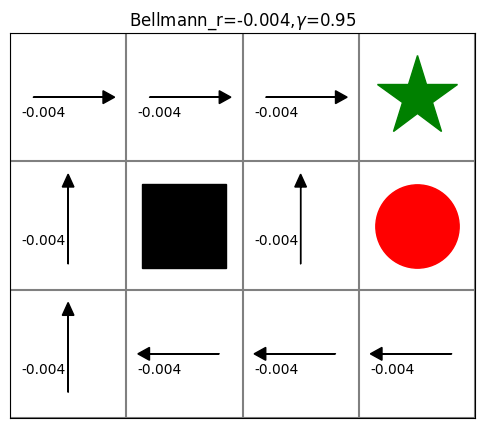

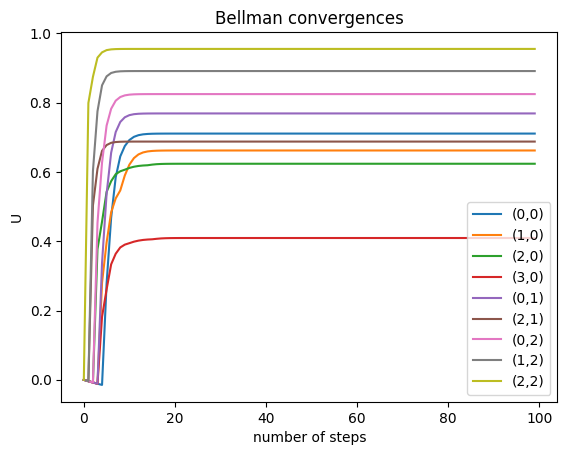

In [26]:

my_title = "Bellmann_r=" + f"{r:,}" + ",$\gamma$=" + f"{Gamma:,}"
plot_policy(policy, title = my_title)
plt.figure()
for j in range(12):
  if (j not in OBSTACLES_indexes) and (j not in ALIVE_indexes) and (j not in DEATH_indexes):
    position_str = "(" + str(j%Nx) + "," + str(int(j/Nx)) + ")"
    plt.plot(U_time[:,j], label =position_str)

U_final = U_time[max_epoch-1,:]
print(U_final)
plt.xlabel("number of steps")
plt.ylabel("U")
plt.title("Bellman convergences")
plt.savefig("Bellman convergences.pdf")
plt.legend()

# Hybrid quantum classical #


## VARIATIONAL QUANTUM CIRCUIT ##

In [36]:

import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

import torch
import torch.nn as nn

def decimalToBinaryFixLength(_length, _decimal):
	binNum = bin(int(_decimal))[2:]
	outputNum = [int(item) for item in binNum]
	if len(outputNum) < _length:
		outputNum = np.concatenate((np.zeros((_length-len(outputNum),)),np.array(outputNum)))
	else:
		outputNum = np.array(outputNum)
	return outputNum

In [37]:
dtype = torch.DoubleTensor

In [38]:
dev = qml.device('default.qubit', wires=4)

In [60]:

@qml.qnode(dev, interface='torch')
def circuit(weights, angles=None):
	"""The circuit of the variational classifier."""
	# Can consider different expectation value
	# PauliX , PauliY , PauliZ , Identity
	for W in weights:
		statepreparation(angles)
		layer(W)
	return [qml.expval(qml.PauliZ(ind)) for ind in range(4)]


def variational_classifier(var_Q_circuit,angles = None):
	weights = var_Q_circuit
	#print("WEIGHTS", weights)
	#print()
	#print()
	#raw_output=torch.tensor(circuit(weights,angles=angles),requires_grad=True).type(dtype) * 2.0-1.0
	raw_output=circuit(weights,angles=angles)
	for i in range(len(raw_output)):
		raw_output[i]=raw_output[i]*3.0
	#print(raw_output)
	return(raw_output)

In [61]:
def statepreparation(a):

	"""Quantum circuit to encode a the input vector into variational params

	Args:
		a: feature vector of rad and rad_square => np.array([rad_X_0, rad_X_1, rad_square_X_0, rad_square_X_1])
	"""

	# Rot to computational basis encoding
	# a = [a_0, a_1, a_2, a_3, a_4, a_5, a_6, a_7, a_8]

	for ind in range(len(a)):
		qml.RX(np.pi * a[ind], wires=ind)
		qml.RZ(np.pi * a[ind], wires=ind)


def layer(W):
	""" Single layer of the variational classifier.

	Args:
		W (array[float]): 2-d array of variables for one layer
	"""

	qml.CNOT(wires=[0, 1])
	qml.CNOT(wires=[1, 2])
	qml.CNOT(wires=[2, 3])


	qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
	qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
	qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
	qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)



In [62]:
def epsilon_greedy(var_Q_circuit, epsilon, n_action, s, train=False):
  if train or np.random.rand()< ((epsilon)):
    action = torch.argmax(torch.tensor(variational_classifier(var_Q_circuit = var_Q_circuit.clone().detach(), angles = decimalToBinaryFixLength(4,s))))
    action = action.item()
  else:
    # need to be torch tensor
    action = np.random.randint(0, 4)
  return action

## Training Loop ##

In [63]:
def sample_random_batch(D,batch_len):
  output = []
  for i in range(batch_len):
    random_index = int(np.random.rand()*len(D))
    output.append(D[random_index])
  return output

In [64]:

loss_fnc = nn.MSELoss()

In [65]:
dtype = torch.DoubleTensor

## Define a FOUR qubit system
dev = qml.device('default.qubit', wires=4)

In [66]:
LR_0 = 0.2
LR_MIN = 0.001
num_games = 20000
max_time = 250
epsilon_0=0.95
N = 700 #Lenght of replay memory
len_batch=1
epsilon_min = 0.05
C=200 #steps
#alpha_0=0.01
#alpha=alpha_0
#alpha_min=0.003
c=0
count = 0
D=[]


best_reward =-10.0
MAE_U =[]
good_Q_print=0.0
good_Q =[]
good_U=[]
bad_U=[]
bad_Q_print=0.0
bad_Q =[]
deep_layers = 2
#initialize random
W = np.random.rand(deep_layers,4,3) * 1.3
W_before =  W.copy()
#initialize a random replay memory
while True:
  if count>=N:
    break
  s_i = random_state()
  while True:
    action = int(np.random.rand()*4)
    s_f = Next_position(s_i,action)
    reward = R[s_f]
    D.append([s_i,action,reward,s_f])
    count = count + 1
    if count>=N:
      break
    if (s_f in ALIVE_indexes) or (s_f in DEATH_indexes):
      break
    s_i = s_f


epsilon=epsilon_0
loss_game=0
loss_games=[]
game_reward=[]
games_reward=[]
good_diff_V = []
bad_diff_V = []
cntr=0
var_init_circuit = torch.tensor(0.3* np.random.randn(deep_layers,4, 3), device='cpu', requires_grad=True).type(dtype)

# Define the two Q value function initial parameters
# Use np copy() function to DEEP COPY the numpy array
var_Q_circuit = var_init_circuit
var_target_Q_circuit = var_Q_circuit.clone().detach()

opt = torch.optim.RMSprop([var_Q_circuit],lr=LR_0, alpha=0.99,eps=1e-08,weight_decay=0,momentum=0,centered=False)
#test
print("TEST")
print(var_Q_circuit)
print(variational_classifier(var_Q_circuit = var_Q_circuit, angles = decimalToBinaryFixLength(4,9)))
print()

scheduler = optim.lr_scheduler.StepLR(opt, step_size=3, gamma=0.5)
MAE_min = 1000.0

print(qml.draw(circuit)(var_Q_circuit, angles = decimalToBinaryFixLength(4,9)))
for m in range(num_games):
  #choose a random state
  s_1 = random_state()
  #s_1=0
  reward_history=[]
  game_reward = 0.0
  cntr=0
  loss_game=0
  for time in range(max_time):
    a = epsilon_greedy(var_Q_circuit = var_Q_circuit, epsilon = epsilon, n_action = 4, s = s_1)
    s_2 = Next_position(s_1,a)
    reward = R[s_2]
    D.append([s_1,a,reward,s_2]) #store in the replay memory
    s_1 = s_2 #reset the state
    if len(D)>=N:
      D.pop(0)   #eliminate too old memories

    #sample minibatch from D

    batch = sample_random_batch(D, len_batch)
    loss=0.0

    for j in range(len_batch):
      s_j, action_j, reward_j, s_jf = batch[j][0],batch[j][1],batch[j][2],batch[j][3]

      #print(s_jf, phi_jf)
      if (s_jf in ALIVE_indexes) or (s_jf in DEATH_indexes):
        y = reward_j+ max(variational_classifier(var_Q_circuit = var_target_Q_circuit, angles = decimalToBinaryFixLength(4,s_jf))) * 0.0
        #print("ALIVE OR DEATH")
      else:
        #print(s_jf)
        #print(variational_classifier(var_Q_circuit = var_target_Q_circuit, angles = decimalToBinaryFixLength(4,s_jf)))
        y = reward_j + Gamma * max(variational_classifier(var_Q_circuit = var_target_Q_circuit, angles = decimalToBinaryFixLength(4,s_jf)))
      #if s_j==10 and action_j ==1:
        #print(y,Q(phi_j)[action_j]
      pred=variational_classifier(var_Q_circuit = var_Q_circuit, angles = decimalToBinaryFixLength(4,s_jf))[action_j]
      #print(pred,pred.type)
      loss +=loss_fnc(pred,y) / len_batch
    #print(loss.type(), y.type(), pred.type())
    #print(pred.grad)
		# print(loss)
    opt.zero_grad()
    #print(type(loss))
    loss.backward()

    opt.step()

    #loss.backward()
    #print(loss, pred.grad)
    #W = quantum_backprop(W,alpha,pred.grad, s_j, action_j, verbose=True)
    #W = quantum_backprop2(W,alpha,batch, verbose=False)
    #print(W)
    #print()

    loss_game+=loss.item()
    reward_history.append(reward)
    cntr+=1
    c+=1
    if c>=C:
      var_target_Q_circuit = var_Q_circuit.clone().detach()
      c=0
      #print("Update of W_before!")

    if (s_2 in ALIVE_indexes) or (s_2 in DEATH_indexes):
      break

  for esponent in range(len(reward_history)):
    game_reward += reward_history[esponent]*Gamma**esponent
  games_reward.append(game_reward)
  loss_games.append(loss_game/cntr)
  epsilon = np.max([epsilon_0 - (float(m+1)/2000),epsilon_min])
  print(cntr)

  if opt.param_groups[0]['lr']> LR_MIN:
    print("Ustep of lr2:", opt.param_groups[0]['lr'])
    scheduler.step()
  if m%20==0 and m>0:
    good_Q_values = variational_classifier(var_Q_circuit = var_Q_circuit, angles = decimalToBinaryFixLength(4,10))
    good_V = torch.max(torch.tensor(good_Q_values)).item()
    good_diff_V.append(good_V- U_final[10])
    good_Q_print = good_Q_values[1]

    bad_Q_values = variational_classifier(var_Q_circuit = var_Q_circuit, angles = decimalToBinaryFixLength(4,3))
    bad_V = torch.max(torch.tensor(bad_Q_values)).item()
    bad_diff_V.append(bad_V - U_final[3])
    bad_Q_print = bad_Q_values[0]
    bad_Q2_print = bad_Q_values[1]
    MAE_value=0.0
    for i in range(12):
      if (i not in ALIVE_indexes) and (i not in DEATH_indexes) and (i not in OBSTACLES_indexes):
        U_tmp = torch.max(torch.tensor(variational_classifier(var_Q_circuit = var_Q_circuit, angles = decimalToBinaryFixLength(4,i))))
        MAE_value+=(U_tmp - U_final[i].item())**2/9.0
    MAE_U.append(MAE_value)
    good_Q.append( good_Q_print)
    bad_Q.append( bad_Q_print)
    #alpha = alpha_0-m*(alpha_0-alpha_min)/num_games
    print("GOOD Q (left to the green):",good_Q_print.item(), ", BAD Q (under the red)", bad_Q_print.item(),", BAD Q 2(left of the red)", bad_Q2_print.item())
    print("GOOD V (left to the green):",good_V, ", BAD V (under the red)", bad_V)
    print("MSE_value=",MAE_value)

    print(qml.draw(circuit)(var_Q_circuit, angles = decimalToBinaryFixLength(4,9)))

    print("Learning rate:", opt.param_groups[0]['lr'],"MSE=",MAE_value)
    print(f"GAME = {m}, LOSSavg20 = {np.mean(loss_games[:-20:]):.8f}, number of steps done in last= {cntr}, last_episode's_last_state = {s_2:.0f}, epsilon = {epsilon:.4f}, game_rewardavg20 = {np.mean(games_reward[:-20:]):.4f}")
    if m>0:
      if MAE_value< MAE_min:
        best_weights = var_Q_circuit.clone().detach()
        MAE_min = MAE_value
  if m==0:
    print(loss_games[0])
  cntr=0
  loss_game=0.0

TEST
tensor([[[ 0.1976, -0.4606,  0.0777],
         [ 0.1888, -0.5475,  0.5672],
         [-0.5354, -0.3602, -0.0691],
         [ 0.2051, -0.1222,  0.0309]],

        [[-0.0896, -0.4574,  0.0929],
         [-0.0407, -0.1834, -0.1007],
         [ 0.2416,  0.7841, -0.0297],
         [-0.1962, -0.1004,  0.3078]]], dtype=torch.float64,
       requires_grad=True)
[tensor(2.1561, dtype=torch.float64, grad_fn=<MulBackward0>), tensor(-2.1696, dtype=torch.float64, grad_fn=<MulBackward0>), tensor(1.4334, dtype=torch.float64, grad_fn=<MulBackward0>), tensor(-2.0847, dtype=torch.float64, grad_fn=<MulBackward0>)]

0: ──RX(3.14)──RZ(3.14)─╭●──Rot(0.20,-0.46,0.08)──RX(3.14)──────────────RZ(3.14)──────────────
1: ──RX(0.00)──RZ(0.00)─╰X─╭●─────────────────────Rot(0.19,-0.55,0.57)──RX(0.00)──────────────
2: ──RX(0.00)──RZ(0.00)────╰X────────────────────╭●─────────────────────Rot(-0.54,-0.36,-0.07)
3: ──RX(3.14)──RZ(3.14)──────────────────────────╰X─────────────────────Rot(0.21,-0.12,0.03)──

──────────

KeyboardInterrupt: 

In [64]:
!pip install torch

## Analysis ##

179


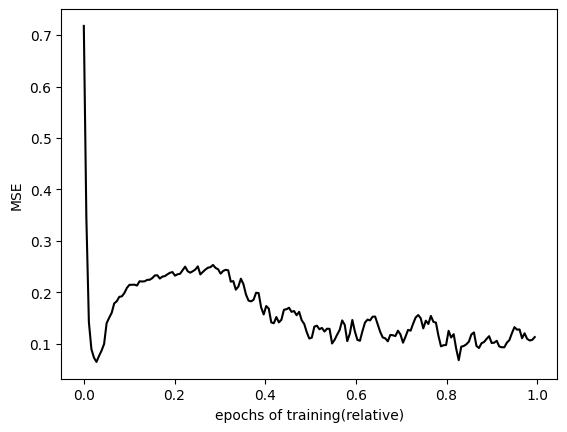

In [67]:
#MAE IN REALITY IS MSE
x_MSE = [float(i)/len(MAE_U) for i in range(len(MAE_U))]
plt.plot(x_MSE,MAE_U, label ="MSE", color="black")

plt.ylabel("MSE")
plt.xlabel("epochs of training(relative)")
print(len(MAE_U)) #firstly 720 alpha 0.01

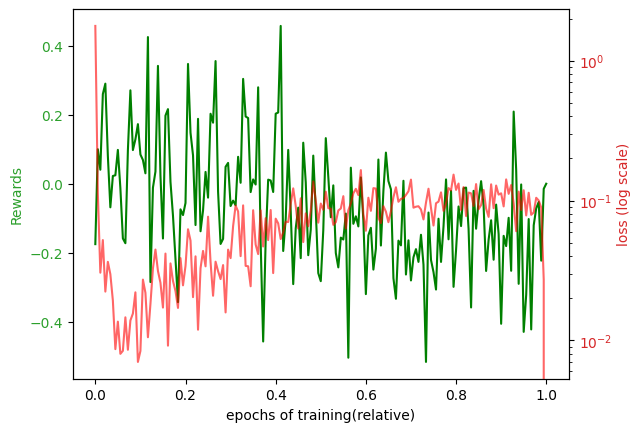

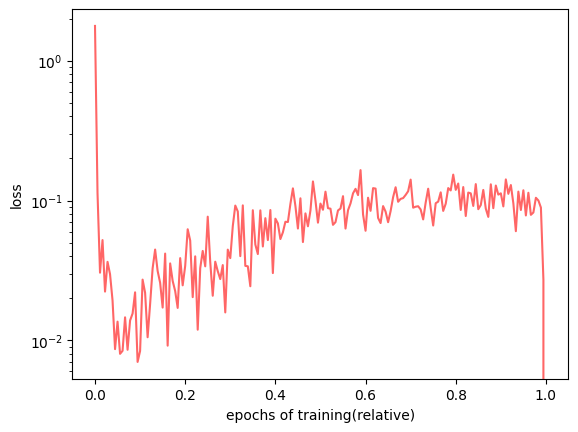

In [68]:

jump_reward = 20
jump_loss = 20
games_reward_means = games_reward
loss_games_means = loss_games
fig, ax1 = plt.subplots()
x_reward = [i/len(games_reward_means[::jump_reward]) for i in range(len(games_reward_means[::jump_reward])+1)]

x_loss = [i/len(loss_games_means[::jump_loss]) for i in range(len(loss_games_means[::jump_loss])+1)]

count =0
index=0

games_reward_means = np.zeros(len(x_reward))
std_reward_games = np.zeros(len(x_reward))
for i in range(len(games_reward)):
  count+=1
  games_reward_means[index]+=games_reward[i]/jump_reward
  if count == jump_reward:
    index+=1
    count=0
index=0
for j in range(len(games_reward)):
  count+=1
  std_reward_games[index]+=(games_reward[i]-games_reward_means[index])**2/jump_reward
  if count == jump_reward:
    std_reward_games[index] = np.sqrt(std_reward_games[index])
    index+=1
    count=0

index=0
loss_games_means = np.zeros(len(x_loss))
for i in range(len(loss_games)):
  count+=1
  loss_games_means[index]+=loss_games[i]/jump_loss
  if count == jump_loss:
    index+=1
    count=0
# Primo plot
color = 'tab:green'
ax1.set_xlabel('epochs of training(relative)')
ax1.set_ylabel('Asse y1', color=color)
ax1.plot(x_reward,games_reward_means,color="green")

#ax1.plot(x_reward,games_reward_means + std_reward_games,color="green", alpha=0.2)
#ax1.plot(x_reward,games_reward_means - std_reward_games,color="green", alpha=0.2)

ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel("Rewards")


# Secondo asse y
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Asse y2', color=color)
ax2.plot(x_loss,loss_games_means, marker="", linestyle ="-", color ="red", alpha =0.6)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale("log")
ax2.set_ylabel("loss (log scale)")

#fig.tight_layout()  # Per aggiustare il layout
plt.savefig("LOSS_REWARD.pdf")
plt.show()
plt.figure()
plt.ylabel("loss")
plt.xlabel("epochs of training(relative)")
plt.plot(x_loss,loss_games_means, marker="", linestyle ="-", color ="red", alpha =0.6)
plt.yscale("log")

[tensor(1.4608, dtype=torch.float64, grad_fn=<MulBackward0>), tensor(1.3035, dtype=torch.float64, grad_fn=<MulBackward0>), tensor(1.0626, dtype=torch.float64, grad_fn=<MulBackward0>), tensor(0.9722, dtype=torch.float64, grad_fn=<MulBackward0>), tensor(0.8892, dtype=torch.float64, grad_fn=<MulBackward0>), tensor(0.9748, dtype=torch.float64, grad_fn=<MulBackward0>), tensor(0.9611, dtype=torch.float64, grad_fn=<MulBackward0>), tensor(0.9646, dtype=torch.float64, grad_fn=<MulBackward0>), tensor(0.9496, dtype=torch.float64, grad_fn=<MulBackward0>), tensor(0.9440, dtype=torch.float64, grad_fn=<MulBackward0>), tensor(0.9226, dtype=torch.float64, grad_fn=<MulBackward0>), tensor(0.9136, dtype=torch.float64, grad_fn=<MulBackward0>), tensor(0.9588, dtype=torch.float64, grad_fn=<MulBackward0>), tensor(0.9129, dtype=torch.float64, grad_fn=<MulBackward0>), tensor(0.9380, dtype=torch.float64, grad_fn=<MulBackward0>), tensor(0.9149, dtype=torch.float64, grad_fn=<MulBackward0>), tensor(0.9372, dtype=to

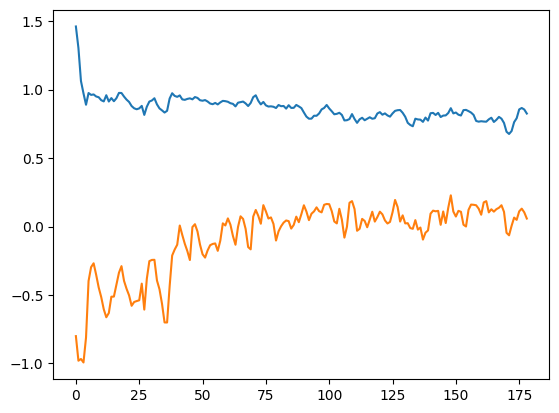

In [69]:
print(good_Q)
plt.plot([i.item() for i in good_Q])

plt.plot([i.item() for i in bad_Q], label="")


c:\Users\andyb\anaconda3\envs\qiskit\Lib\site-packages\pennylane\math\utils.py:228: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


0.4553359724071072
0.4553359724071064
0.36888591951698846
0.3688859195169883
0.12644993270332
0.08255806193052273
0.845716570777465
0.845716570777464
0.845716570777464


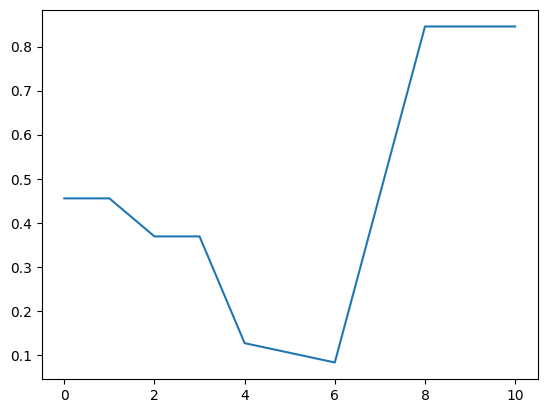

In [70]:
def Q(s,W):
  return variational_classifier(var_Q_circuit = W, angles = decimalToBinaryFixLength(4,s))

policy_DEEP = np.zeros(Nx*Ny)
U_DEEP = np.zeros(12)
for s in range(Nx*Ny):
  #action = torch.argmax(torch.tensor(Q(s,best_weights)))
  action = torch.argmax(torch.tensor(Q(s,var_Q_circuit)))
  policy_DEEP[s] = action
  #U_DEEP[s] = torch.max(torch.tensor(Q(s,best_weights))).item()
  U_DEEP[s] = torch.max(torch.tensor(Q(s,var_Q_circuit))).item()

U_PLOT_DEEP = []
for s in range(Nx*Ny):
  if (s not in ALIVE_indexes) and  (s not in DEATH_indexes) and (s not in OBSTACLES_indexes):
    print(U_DEEP[s])
    U_PLOT_DEEP.append(U_DEEP[s])
    
index_CORRECT = [0,1,2,3,4,6,8,9,10]

plt.plot(index_CORRECT,U_PLOT_DEEP)

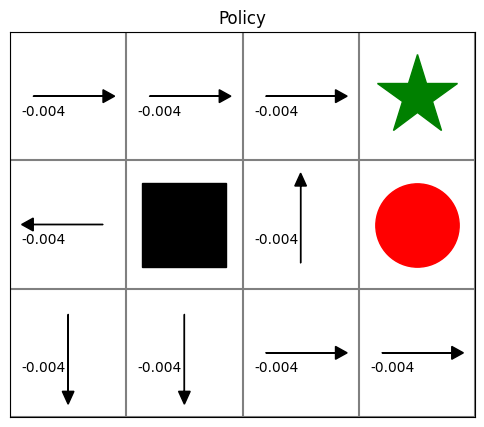

In [71]:
my_title="Policy"
plot_policy(policy_DEEP, title = my_title)